In [1]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

2025-09-02 10:59:43.749423: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 10:59:44.871365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756832385.208771  119068 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756832385.283195  119068 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-02 10:59:46.585781: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [26]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='${SCRATCH}/junk/', 
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(5)

# Setup your client
client = Client(cluster)

In [4]:
def pxbmean(da):
    f='/glade/u/home/linnia/ctsm6_ppe/utils/lapxb_sg_sudoku3_ctsm53017.nc'
    lapxb=xr.open_dataset(f).lapxb_sg
    x=(lapxb*da).sum(dim=['pft','vegtype'])/(lapxb).sum(dim=['pft','vegtype'])
    xm=x.mean(dim='year')
    return x

In [5]:
def sudoku_biome_mean(ds):
    biome_masks=xr.open_dataset('~/ctsm6_ppe/biomes/sudoku_biomes_v3.nc')
    d='/glade/work/linnia/CLM6-PPE/BNF_v2.n01_ctsm5.3.012_transient_SP/run/'
    f=glob.glob(d+'*clm2.h0.*')[0]
    ds_sp=xr.open_dataset(f,decode_timedelta=False)
    
    biome_mean = ((ds_sp.area * ds_sp.landfrac * ds).groupby(biome_masks.sudoku_biomes).sum()
    / ((ds_sp.area * ds_sp.landfrac).groupby(biome_masks.sudoku_biomes).sum()))

    return biome_mean.compute()

In [6]:
biome_names=xr.open_dataset('~/ctsm6_ppe/biomes/sudoku_biomes_v3.nc').biome_names

### Load observations

In [7]:
# load observations
obs = xr.open_dataset('observational_data.nc')

### Load sparsegrid tests

In [28]:
base_path = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_'
#ensemble_ids = [f"caltest{str(i).zfill(4)}" for i in range(86, 91)]
ensemble_ids = ['cal115_c08132025']

In [29]:
dvs = ['TOTVEGC','GPP','TLAI','EFLX_LH_TOT','ER','TOTSOMC_1m']

def pp(ds):
    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    return ds[dvs]

In [30]:
# load test ensemble

all_datasets = []

for ens_index, ens_id in enumerate(ensemble_ids):
    path = os.path.join(base_path + ens_id, 'run', '*.h0.*')
    files = sorted(glob.glob(path))
    
    if not files:
        print(f"No files found for ensemble {ens_id}")
        continue
    
    ds = xr.open_mfdataset(files[28:], preprocess=pp)
    ds = ds.expand_dims(ens=[ens_index])
    all_datasets.append(ds)

combined_ds = xr.concat(all_datasets, dim='ens')

# calculate 
lai = amax(combined_ds['TLAI']).sel(year=slice('2001','2020')).mean(dim='year')
sg_lai = get_map(lai)
gpp = (60*60*24)*amean(combined_ds['GPP']).sel(year=slice('2001','2015')).mean(dim='year')
sg_gpp = get_map(gpp)
tvc = (1/1000)*amean(combined_ds['TOTVEGC']).sel(year=slice('2000','2019')).mean(dim='year')
sg_tvc = get_map(tvc)
et=amean(combined_ds['EFLX_LH_TOT'].sel(time=slice('2000','2014'))).mean(dim='year')
sg_lh = get_map(et)

### Load full grid CLM I-cases

In [15]:
dvs = ['TOTVEGC','FSH','GPP','TLAI','EFLX_LH_TOT','TOTSOMC_1m','BTRANMN','area','landfrac']

def pp(ds):
    return ds[dvs]

In [16]:
# load default
path = os.path.join('/glade/derecho/scratch/wwieder/archive/ctsm53041_54surfdata_PPEbaseline_101_HIST/lnd/hist/', '*.h0.*')
files = sorted(glob.glob(path))[-288:]
fg_default = xr.open_mfdataset(files,preprocess=pp)

def_lai = amax(fg_default.TLAI).sel(year=slice('2001','2020')).mean(dim='year')
def_gpp = (60*60*24)*amean(fg_default.GPP).sel(year=slice('2001','2015')).mean(dim='year')
def_tvc = (1/1000)*amean(fg_default.TOTVEGC).sel(year=slice('2000','2019')).mean(dim='year')
def_lh = amean(fg_default.EFLX_LH_TOT).sel(year=slice('2000','2014')).mean(dim='year')

def_lai_bmean = sudoku_biome_mean(def_lai)
def_gpp_bmean = sudoku_biome_mean(def_gpp)
def_tvc_bmean = sudoku_biome_mean(def_tvc)
def_lh_bmean = sudoku_biome_mean(def_lh)

In [17]:
dir = '/glade/derecho/scratch/wwieder/archive/'
cases = ['ctsm53065_54surfdata_PPEcal115_115_HIST']

In [18]:
# load ensemble of full grid tests h0
ds_list = []

for case in cases:
    path = os.path.join(dir + case + '/lnd/hist/', '*.h0a.*')
    files = sorted(glob.glob(path)) #[-288:]
    ds = xr.open_mfdataset(files,preprocess=pp)

    ds = ds.expand_dims(dim={'ens': [case]})  # Add new ens dimension
    ds_list.append(ds)

master_ds = xr.concat(ds_list, dim='ens')

In [19]:
fg_lai = amax(master_ds.TLAI).sel(year=slice('2001','2020')).mean(dim='year')
fg_gpp = (60*60*24)*amean(master_ds.GPP).sel(year=slice('2001','2015')).mean(dim='year')
fg_tvc = (1/1000)*amean(master_ds.TOTVEGC).sel(year=slice('2000','2019')).mean(dim='year')
fg_lh = amean(master_ds.EFLX_LH_TOT).sel(year=slice('2000','2014')).mean(dim='year')
fg_sh = amax(master_ds.FSH).sel(year=slice('2000','2014')).mean(dim='year')

In [20]:
fg_lai_bmean = sudoku_biome_mean(fg_lai)
fg_gpp_bmean = sudoku_biome_mean(fg_gpp)
fg_tvc_bmean = sudoku_biome_mean(fg_tvc)
fg_lh_bmean = sudoku_biome_mean(fg_lh)
fg_sh_bmean = sudoku_biome_mean(fg_sh)

In [21]:
# check soil C
la = (master_ds.area*master_ds.landfrac).isel(time=0,ens=0)
fg_somc = amean(master_ds.TOTSOMC_1m).mean(dim='year')
fg_somc_gmean = 1E-9*la.sum()*gmean(fg_somc,la)
fg_somc_gmean.values

array([1641.93096361])

### Map biases

In [31]:
def plot_model_diffs(var, obs, default, full_grid, sparse_grid=None, 
                     vmin=-6, vmax=6, cmap='PRGn', savepath=None):

    fig, axes = plt.subplots(1, 3, figsize=(14, 6),
                             subplot_kw={'projection': ccrs.Robinson()})
    plt.rcParams['font.size'] = 14

    cropmask = xr.open_dataset(utils_path+'cropmask.nc')
    crop_mask = (cropmask.crop == 0)
    lf = xr.open_dataset(utils_path+'CLM-SP_amaxTLAI.nc').landfrac

    # default-obs
    ax = axes[0]
    diff = (default*lf - obs) * crop_mask.values
    rmse = np.round(np.sqrt((diff ** 2).mean()).values, 3)

    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
    pcm = ax.pcolormesh(obs.lon, obs.lat, diff,
                        transform=ccrs.PlateCarree(), shading='auto',
                        cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
    cbar.set_label(var, size=14)
    ax.set_title('Default - Observed \n RMSE = '+str(rmse))

    # fullgrid-obs
    ax = axes[1]
    diff = (full_grid*lf - obs) * crop_mask.values
    rmse = np.round(np.sqrt((diff ** 2).mean()).values, 3)

    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
    pcm = ax.pcolormesh(obs.lon, obs.lat, diff,
                        transform=ccrs.PlateCarree(), shading='auto',
                        cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
    cbar.set_label(var, size=14)
    ax.set_title('Tuned - Observed \n full grid I-case \n RMSE = '+str(rmse))

    # sparse grid-obs
    if sparse_grid is not None:
        ax = axes[2]
        diff = (sparse_grid*lf - obs) * crop_mask.values
        rmse = np.round(np.sqrt((diff ** 2).mean()).values, 3)
    
        ax.coastlines()
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
        pcm = ax.pcolormesh(obs.lon, obs.lat, diff,
                            transform=ccrs.PlateCarree(), shading='auto',
                            cmap=cmap, vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
        cbar.set_label(var, size=14)
        ax.set_title('Tuned - Observed \n sparse grid \n RMSE = '+str(rmse))
    
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()


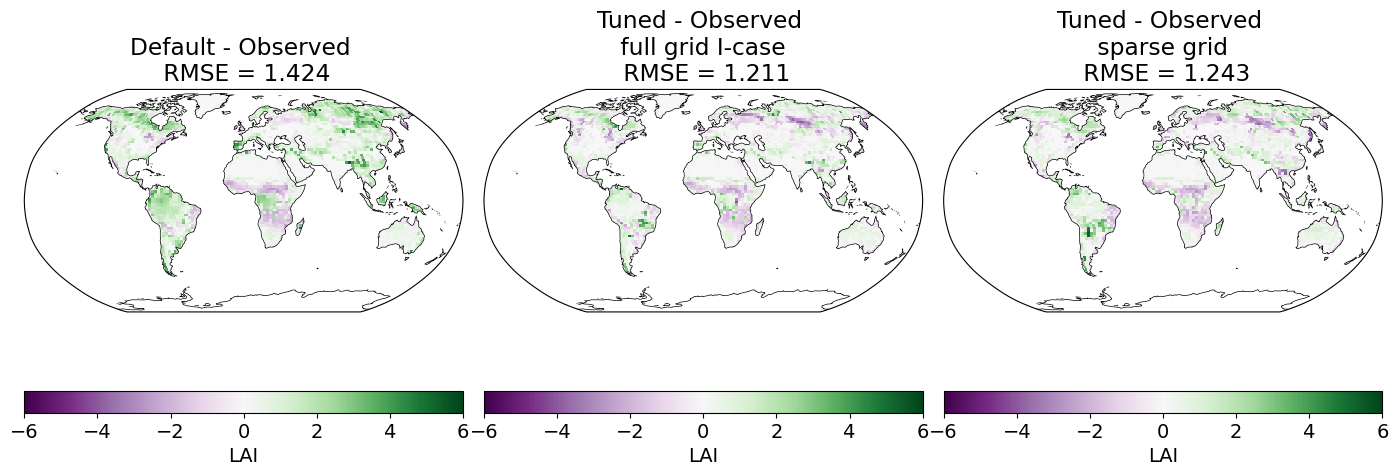

In [32]:
e=0
savepath='../figs/cal115_fullgrid_laibias.png'
plot_model_diffs('LAI', obs.LAI, def_lai, fg_lai.isel(ens=e), sparse_grid=sg_lai.isel(ens=e), 
                     vmin=-6, vmax=6, cmap='PRGn', savepath=savepath)

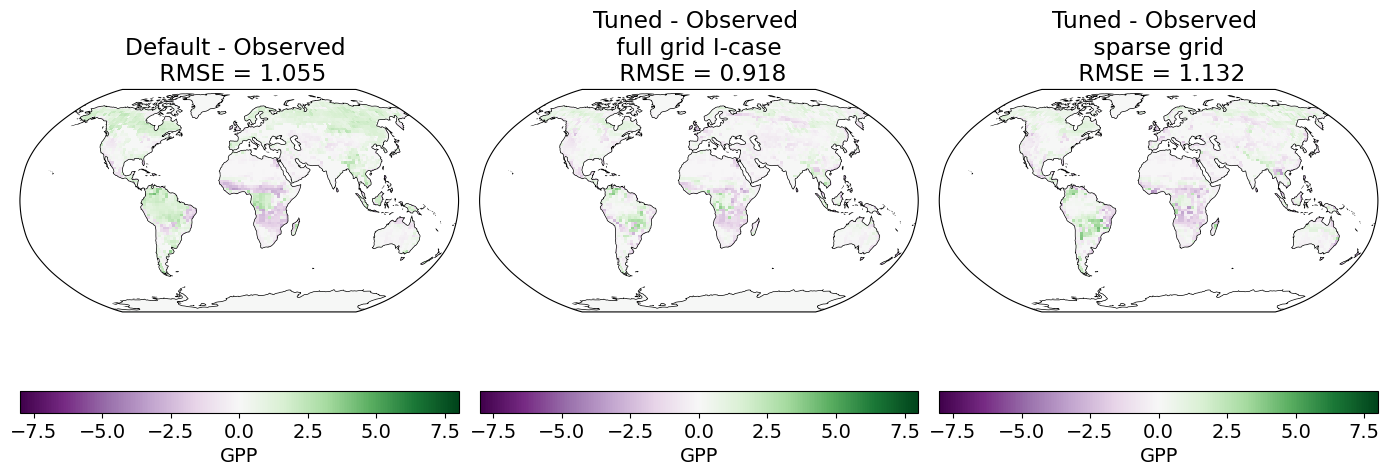

In [33]:
e=0
savepath='../figs/cal115_fullgrid_gppbias.png'
plot_model_diffs('GPP', obs.GPP, def_gpp, fg_gpp.isel(ens=e), sg_gpp.isel(ens=e), 
                     vmin=-8, vmax=8, cmap='PRGn', savepath=savepath)

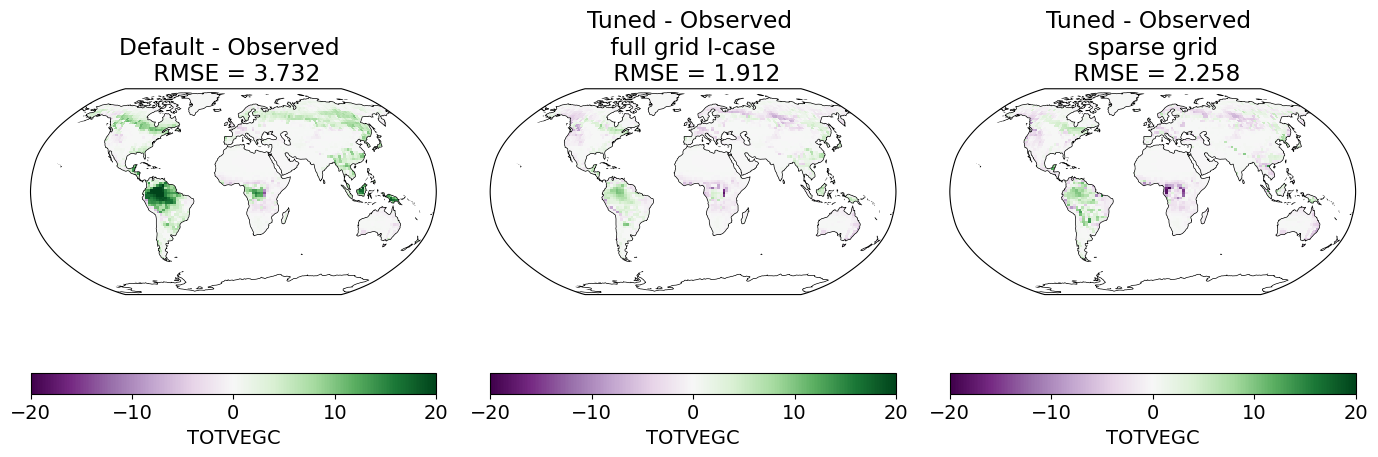

In [34]:
e=0
savepath='../figs/cal115_fullgrid_tvcbias.png'
plot_model_diffs('TOTVEGC', obs.TOTVEGC, def_tvc, fg_tvc.isel(ens=e), sg_tvc.isel(ens=e), 
                     vmin=-20, vmax=20, cmap='PRGn', savepath=savepath)

### whats up with crops?

In [11]:
import xarray as xr


def amean(da):
    #annual mean of monthly data
    m  = da['time.daysinmonth']
    cf = 1/365
    xa = cf*(m*da).groupby('time.year').sum().compute()
    return xa

In [12]:
in_file = '/glade/derecho/scratch/wwieder/ADF_unstruct/ctsm5.4_5.3.068_PPEcal115_116_HIST/ts/ctsm5.4_5.3.068_PPEcal115_116_HIST.clm2.h0a.TOTSOMC_1m.185001-202312.nc'
somc_116 = xr.open_dataset(in_file,decode_times=True)

In [13]:
da = amean(somc_116.TOTSOMC_1m)
la = somc_116.area*somc_116.landfrac
x=(da*la).sum(dim='lndgrid')/la.sum()
cf = 1E-9*la.sum()
gmean_somc = (x * cf)

In [14]:
# finite volume 2degree cal115 simulation
la = (master_ds.area*master_ds.landfrac).isel(ens=0)
fg_somc = amean(master_ds.TOTSOMC_1m)
tmp = gmean(fg_somc.squeeze(),la).mean(dim='time')
fg_somc_gmean = 1E-9*la.sum()*tmp

In [ ]:
fg_somc_gmean.plot()
gmean_somc.plot()
plt.legend()
plt.ylabel('PgC')

Text(0, 0.5, 'change in SOMC (PgC)')

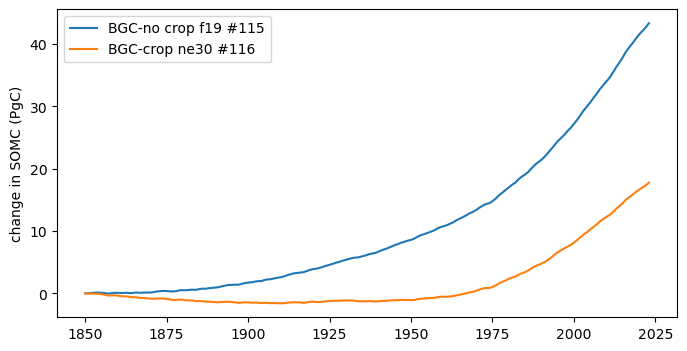

In [23]:
plt.figure(figsize=(8,4))
yr = range(1850,2024)
plt.plot(yr,fg_somc_gmean - fg_somc_gmean.isel(year=0),label='BGC-no crop f19 #115')
plt.plot(yr,gmean_somc - gmean_somc.isel(year=0),label='BGC-crop ne30 #116')
plt.legend()
plt.ylabel('change in SOMC (PgC)')

## Map

In [25]:
!pip install uxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 MB 107.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 19.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 62.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 105.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 126.6 MB/s eta 0:00:0000:01
  Attempting uninstall: contourpy
    Found existing installation: contourpy 1.0.2
    Uninstalling contourpy-1.0.2:
      Successfully uninstalled contourpy-1.0.2


In [32]:
import uxarray as uxarray

In [35]:
in_file = '/glade/derecho/scratch/wwieder/ADF_unstruct/ctsm5.4_5.3.068_PPEcal115_116_HIST/ts/ctsm5.4_5.3.068_PPEcal115_116_HIST.clm2.h0a.TOTSOMC_1m.185001-202312.nc'
somc = uxarray.open_dataset(filename_or_obj=in_file)

TypeError: open_dataset() missing 1 required positional argument: 'grid_filename_or_obj'

In [ ]:
## Map